In [ ]:
# from 
# https://gist.githubusercontent.com/piyueh/712ec7d4540489aad2dcfb80f9a54993/raw/f8121b52fca3518435833761bf5e8c3c706efce1/tf_keras_tfp_lbfgs.py

In [1]:
#! /usr/bin/env python
# -*- coding: utf-8 -*-
# vim:fenc=utf-8
#
# Copyright © 2019 Pi-Yueh Chuang <pychuang@gwu.edu>
#
# Distributed under terms of the MIT license.

"""An example of using tfp.optimizer.lbfgs_minimize to optimize a TensorFlow model.

This code shows a naive way to wrap a tf.keras.Model and optimize it with the L-BFGS
optimizer from TensorFlow Probability.

Python interpreter version: 3.6.9
TensorFlow version: 2.0.0
TensorFlow Probability version: 0.8.0
NumPy version: 1.17.2
Matplotlib version: 3.1.1
"""
import numpy
import tensorflow as tf
import tensorflow_probability as tfp
from matplotlib import pyplot

def function_factory(model, loss, train_x, train_y):
    """A factory to create a function required by tfp.optimizer.lbfgs_minimize.

    Args:
        model [in]: an instance of `tf.keras.Model` or its subclasses.
        loss [in]: a function with signature loss_value = loss(pred_y, true_y).
        train_x [in]: the input part of training data.
        train_y [in]: the output part of training data.

    Returns:
        A function that has a signature of:
            loss_value, gradients = f(model_parameters).
    """

    # obtain the shapes of all trainable parameters in the model
    shapes = tf.shape_n(model.trainable_variables)
    n_tensors = len(shapes)

    # we'll use tf.dynamic_stitch and tf.dynamic_partition later, so we need to
    # prepare required information first
    count = 0
    idx = [] # stitch indices
    part = [] # partition indices

    for i, shape in enumerate(shapes):
        n = numpy.product(shape)
        idx.append(tf.reshape(tf.range(count, count+n, dtype=tf.int32), shape))
        part.extend([i]*n)
        count += n

    part = tf.constant(part)

    @tf.function
    def assign_new_model_parameters(params_1d):
        """A function updating the model's parameters with a 1D tf.Tensor.

        Args:
            params_1d [in]: a 1D tf.Tensor representing the model's trainable parameters.
        """

        params = tf.dynamic_partition(params_1d, part, n_tensors)
        for i, (shape, param) in enumerate(zip(shapes, params)):
            model.trainable_variables[i].assign(tf.reshape(param, shape))

    # now create a function that will be returned by this factory
    @tf.function
    def f(params_1d):
        """A function that can be used by tfp.optimizer.lbfgs_minimize.

        This function is created by function_factory.

        Args:
           params_1d [in]: a 1D tf.Tensor.

        Returns:
            A scalar loss and the gradients w.r.t. the `params_1d`.
        """

        # use GradientTape so that we can calculate the gradient of loss w.r.t. parameters
        with tf.GradientTape() as tape:
            # update the parameters in the model
            assign_new_model_parameters(params_1d)
            # calculate the loss
            loss_value = loss(model(train_x, training=True), train_y)

        # calculate gradients and convert to 1D tf.Tensor
        grads = tape.gradient(loss_value, model.trainable_variables)
        grads = tf.dynamic_stitch(idx, grads)

        # print out iteration & loss
        f.iter.assign_add(1)
        tf.print("Iter:", f.iter, "loss:", loss_value)

        # store loss value so we can retrieve later
        tf.py_function(f.history.append, inp=[loss_value], Tout=[])

        return loss_value, grads

    # store these information as members so we can use them outside the scope
    f.iter = tf.Variable(0)
    f.idx = idx
    f.part = part
    f.shapes = shapes
    f.assign_new_model_parameters = assign_new_model_parameters
    f.history = []

    return f

def plot_helper(inputs, outputs, title, fname):
    """Plot helper"""
    pyplot.figure()
    pyplot.tricontourf(inputs[:, 0], inputs[:, 1], outputs.flatten(), 100)
    pyplot.xlabel("x")
    pyplot.ylabel("y")
    pyplot.title(title)
    pyplot.colorbar()
    pyplot.savefig(fname)



# main

In [10]:
# use float64 by default
tf.keras.backend.set_floatx("float64")

# prepare training data
x_1d = numpy.linspace(-1., 1., 11)
x1, x2 = numpy.meshgrid(x_1d, x_1d)
inps = numpy.stack((x1.flatten(), x2.flatten()), 1)
outs = numpy.reshape(inps[:, 0]**2+inps[:, 1]**2, (x_1d.size**2, 1))


In [11]:
inps.shape

(121, 2)

In [12]:
outs.shape

(121, 1)

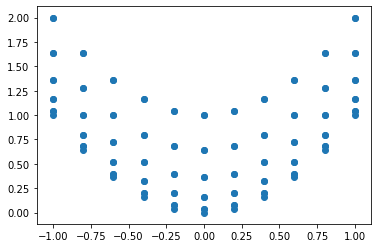

In [13]:
pyplot.figure()
pyplot.scatter(inps[:,1], outs[:,0])

In [21]:
len(results)

9

In [26]:
results.position

<tf.Tensor: shape=(4417,), dtype=float64, numpy=
array([-0.07736755, -0.77444819,  0.11358696, ..., -0.22997275,
        0.44191792,  6.02681044])>

In [27]:
init_params

<tf.Tensor: shape=(4417,), dtype=float64, numpy=
array([ 0.13161713,  0.04766403, -0.25511123, ..., -0.18606353,
        0.27631079,  0.        ])>

In [19]:
# prepare prediction model, loss function, and the function passed to L-BFGS solver
pred_model = tf.keras.Sequential(
    [tf.keras.Input(shape=[2,]),
     tf.keras.layers.Dense(64, "tanh"),
     tf.keras.layers.Dense(64, "tanh"),
     tf.keras.layers.Dense(1, None)])

loss_fun = tf.keras.losses.MeanSquaredError()
func = function_factory(pred_model, loss_fun, inps, outs)

# convert initial model parameters to a 1D tf.Tensor
init_params = tf.dynamic_stitch(func.idx, pred_model.trainable_variables)

# train the model with L-BFGS solver
results = tfp.optimizer.lbfgs_minimize(
    value_and_gradients_function=func, initial_position=init_params, max_iterations=500)


Iter: 1 loss: 0.90583878755569458
Iter: 2 loss: 32.289360046386719
Iter: 3 loss: 0.76712387800216675
Iter: 4 loss: 0.263447642326355
Iter: 5 loss: 0.25972062349319458
Iter: 6 loss: 0.27570793032646179
Iter: 7 loss: 0.25898727774620056
Iter: 8 loss: 0.258311003446579
Iter: 9 loss: 0.26365020871162415
Iter: 10 loss: 0.25826352834701538
Iter: 11 loss: 0.25809201598167419
Iter: 12 loss: 0.25744876265525818
Iter: 13 loss: 0.25520077347755432
Iter: 14 loss: 0.26369768381118774
Iter: 15 loss: 0.25442114472389221
Iter: 16 loss: 0.24887734651565552
Iter: 17 loss: 0.32415708899497986
Iter: 18 loss: 0.24836979806423187
Iter: 19 loss: 0.24592851102352142
Iter: 20 loss: 0.254067063331604
Iter: 21 loss: 0.24584141373634338
Iter: 22 loss: 0.24487513303756714
Iter: 23 loss: 0.24486075341701508
Iter: 24 loss: 0.24420104920864105
Iter: 25 loss: 0.24712979793548584
Iter: 26 loss: 0.2440800815820694
Iter: 27 loss: 0.24357424676418304
Iter: 28 loss: 0.24323354661464691
Iter: 29 loss: 0.24297934770584106
It

In [30]:
results.position

<tf.Tensor: shape=(4417,), dtype=float64, numpy=
array([-0.07736755, -0.77444819,  0.11358696, ..., -0.22997275,
        0.44191792,  6.02681044])>

In [31]:
init_params

<tf.Tensor: shape=(4417,), dtype=float64, numpy=
array([ 0.13161713,  0.04766403, -0.25511123, ..., -0.18606353,
        0.27631079,  0.        ])>

In [35]:
# convert initial model parameters to a 1D tf.Tensor
# init_params = tf.dynamic_stitch(func.idx, pred_model.trainable_variables)
init_params = results.position

# train the model with L-BFGS solver
results = tfp.optimizer.lbfgs_minimize(
    value_and_gradients_function=func, initial_position=init_params, max_iterations=500)

Iter: 2880 loss: 2.4992203861984308e-07
Iter: 2881 loss: 2.5439260298298905e-07
Iter: 2882 loss: 2.4990325186990958e-07
Iter: 2883 loss: 2.4987599545056582e-07
Iter: 2884 loss: 2.4986206881294493e-07
Iter: 2885 loss: 2.4984930746541067e-07
Iter: 2886 loss: 2.49834272381122e-07
Iter: 2887 loss: 2.4978018586807593e-07
Iter: 2888 loss: 2.4965595457615564e-07
Iter: 2889 loss: 2.5269019943152671e-07
Iter: 2890 loss: 2.4965595457615564e-07
Iter: 2891 loss: 2.4959129518720147e-07
Iter: 2892 loss: 2.4942957566054247e-07
Iter: 2893 loss: 2.5094840339079383e-07
Iter: 2894 loss: 2.4940678144957928e-07
Iter: 2895 loss: 2.4956952415777778e-07
Iter: 2896 loss: 2.49325211143514e-07
Iter: 2897 loss: 2.4929005348894862e-07
Iter: 2898 loss: 2.4915448193496559e-07
Iter: 2899 loss: 2.4859852487679746e-07
Iter: 2900 loss: 2.4886568894544325e-07
Iter: 2901 loss: 2.4809020260363468e-07
Iter: 2902 loss: 2.476213296631613e-07
Iter: 2903 loss: 2.4728379344196583e-07
Iter: 2904 loss: 2.4712178969821252e-07
Iter:

L2-error norm: 0.0011419019627137502


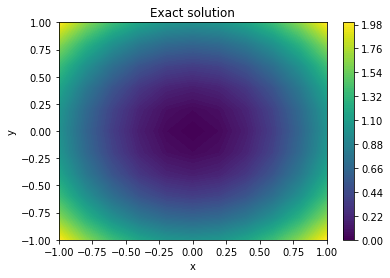

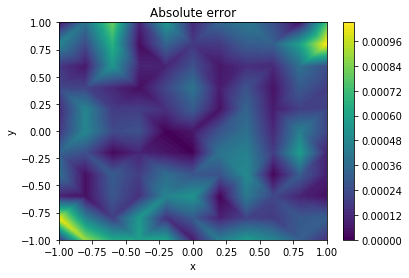


History
tf.Tensor(0.9058387875556946, shape=(), dtype=float64)
tf.Tensor(32.28936004638672, shape=(), dtype=float64)
tf.Tensor(0.7671238780021667, shape=(), dtype=float64)
tf.Tensor(0.263447642326355, shape=(), dtype=float64)
tf.Tensor(0.2597206234931946, shape=(), dtype=float64)
tf.Tensor(0.2757079303264618, shape=(), dtype=float64)
tf.Tensor(0.25898727774620056, shape=(), dtype=float64)
tf.Tensor(0.258311003446579, shape=(), dtype=float64)
tf.Tensor(0.26365020871162415, shape=(), dtype=float64)
tf.Tensor(0.2582635283470154, shape=(), dtype=float64)
tf.Tensor(0.2580920159816742, shape=(), dtype=float64)
tf.Tensor(0.2574487626552582, shape=(), dtype=float64)
tf.Tensor(0.2552007734775543, shape=(), dtype=float64)
tf.Tensor(0.26369768381118774, shape=(), dtype=float64)
tf.Tensor(0.2544211447238922, shape=(), dtype=float64)
tf.Tensor(0.24887734651565552, shape=(), dtype=float64)
tf.Tensor(0.32415708899497986, shape=(), dtype=float64)
tf.Tensor(0.24836979806423187, shape=(), dtype=float64

In [36]:

# after training, the final optimized parameters are still in results.position
# so we have to manually put them back to the model
func.assign_new_model_parameters(results.position)

# do some prediction
pred_outs = pred_model.predict(inps)
err = numpy.abs(pred_outs-outs)
print("L2-error norm: {}".format(numpy.linalg.norm(err)/numpy.sqrt(11)))

# plot figures
plot_helper(inps, outs, "Exact solution", "ext_soln.png")
plot_helper(inps, pred_outs, "Predicted solution", "pred_soln.png")
plot_helper(inps, err, "Absolute error", "abs_err.png")
pyplot.show()

# print out history
print("\n"+"="*80)
print("History")
print("="*80)
print(*func.history, sep='\n')